Overview

The data has been split into two groups:

    training set (train.csv)
    test set (test.csv)

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

Data Dictionary
Variable	Definition	Key
survival 	Survival 	0 = No, 1 = Yes
pclass 	Ticket class 	1 = 1st, 2 = 2nd, 3 = 3rd
sex 	Sex 	
Age 	Age in years 	
sibsp 	# of siblings / spouses aboard the Titanic 	
parch 	# of parents / children aboard the Titanic 	
ticket 	Ticket number 	
fare 	Passenger fare 	
cabin 	Cabin number 	
embarked 	Port of Embarkation 	C = Cherbourg, Q = Queenstown, S = Southampton
Variable Notes

pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

https://www.encyclopedia-titanica.org/titanic-deckplans/

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from matplotlib import cm
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score, precision_score, recall_score

In [34]:
titanic = pd.read_csv('Titanic.csv', sep=',')

In [35]:
df = pd.DataFrame(titanic)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [36]:
diedSurvived = []
for person in df['Survived']:
    if person == 0:
        diedSurvived.append('Died')
    elif person == 1:
        diedSurvived.append('Survived')
df['diedSurvived'] = diedSurvived        

## Uklanjanje nepostojećih

In [37]:
df.dropna(subset=['Embarked'], inplace=True)
df.dropna(subset=['Age'], inplace=True)
df.dropna(subset=['Sex'], inplace=True)
df.reset_index(drop=True, inplace=True)
len(df)

712

## Label encoder

In [38]:
le = LabelEncoder()

SexL = le.fit_transform(df['Sex'])
EmbarkedL = le.fit_transform(df['Embarked'])

df['SexL'] = SexL
df['EmbarkedL'] = EmbarkedL

## OneHot encoder

In [39]:
enc = OneHotEncoder(categories = 'auto')

Sex = le.fit_transform(df['Sex'])

Sex = Sex.reshape(-1,1)

enc.fit(Sex)
onehotlabels = enc.transform(Sex).toarray()
Sex = pd.DataFrame(onehotlabels)

print(le.classes_)
Sex.columns = ['Sex: female', 'Sex: male']
Sex.reset_index(drop=True, inplace=True)

Embarked = le.fit_transform(df['Embarked'])

Embarked = Embarked.reshape(-1,1)

enc.fit(Embarked)
onehotlabels = enc.transform(Embarked).toarray()
Embarked = pd.DataFrame(onehotlabels)

print(le.classes_)
Embarked.columns = ['Embarked: C', 'Embarked: Q', 'Embarked: S']
Embarked.reset_index(drop=True, inplace=True)

df = pd.concat([df, Sex, Embarked], axis=1, sort=False).reindex(df.index)

['female' 'male']
['C' 'Q' 'S']


In [40]:
df1 = ['PassengerId', 'Pclass', 'Name', 'Sex','SexL', 'Sex: female', 'Sex: male', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'EmbarkedL', 'Embarked: C', 'Embarked: Q', 'Embarked: S', 'diedSurvived', 'Survived']
df = df[df1]

In [41]:
df[['Sex: male', 'Sex: female', 'Embarked: C', 'Embarked: Q', 'Embarked: S']].head()

,Sex: male,Sex: female,Embarked: C,Embarked: Q,Embarked: S
0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0


In [42]:
df.head()

,PassengerId,Pclass,Name,Sex,SexL,Sex: female,Sex: male,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,EmbarkedL,Embarked: C,Embarked: Q,Embarked: S,diedSurvived,Survived
0,1,3,"Braund, Mr. Owen Harris",male,1,0.0,1.0,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0.0,0.0,1.0,Died,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,0,1.0,0.0,38.0,1,0,PC 17599,71.2833,C85,C,0,1.0,0.0,0.0,Survived,1
2,3,3,"Heikkinen, Miss. Laina",female,0,1.0,0.0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2,0.0,0.0,1.0,Survived,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,0,1.0,0.0,35.0,1,0,113803,53.1000,C123,S,2,0.0,0.0,1.0,Survived,1
4,5,3,"Allen, Mr. William Henry",male,1,0.0,1.0,35.0,0,0,373450,8.0500,NaN,S,2,0.0,0.0,1.0,Died,0


In [26]:
klaseTitanika = dict(list(zip(df.Survived.unique(), df.diedSurvived.unique())))

# Grafovi

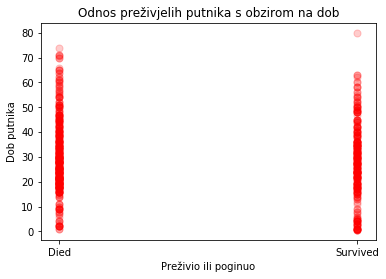

In [11]:
x = df['diedSurvived']
y = df['Age']

plt.xlabel('Preživio ili poginuo')
plt.ylabel('Dob putnika')
plt.title('Odnos preživjelih putnika s obzirom na dob')
plt.scatter(x, y, c='red', s=50, alpha=0.20)
plt.savefig('ScatterSurvivedAge.png', dpi=200)
plt.show()

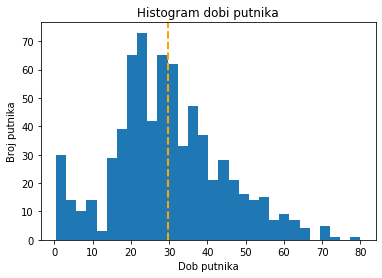

In [12]:
df['Age'].plot.hist(bins=30) 

plt.xlabel('Dob putnika')
plt.ylabel('Broj putnika')
plt.title('Histogram dobi putnika')
plt.axvline(df['Age'].mean(), color='orange', linestyle='dashed', linewidth=2)
plt.savefig('HistAge.png', dpi=200)

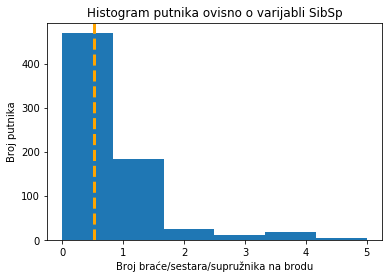

In [13]:
df['SibSp'].plot.hist(bins=6) 

plt.xlabel('Broj braće/sestara/supružnika na brodu')
plt.ylabel('Broj putnika')
plt.title('Histogram putnika ovisno o varijabli SibSp')
plt.axvline(df['SibSp'].mean(), color='orange', linestyle='dashed', linewidth=3)
plt.savefig('HistSibSp.png', dpi=200)

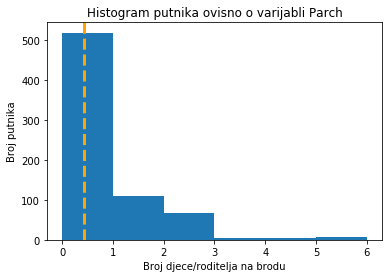

In [14]:
df['Parch'].plot.hist(bins=6) 

plt.xlabel('Broj djece/roditelja na brodu')
plt.ylabel('Broj putnika')
plt.title('Histogram putnika ovisno o varijabli Parch')
plt.axvline(df['Parch'].mean(), color='orange', linestyle='dashed', linewidth=3)
plt.savefig('HistParch.png', dpi=200)

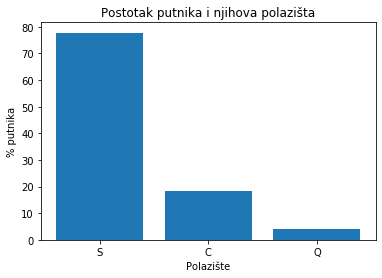

In [15]:
plt.bar(x=df['Embarked'].value_counts(True).index,  height=df['Embarked'].value_counts(True).get_values()*100)

plt.xlabel('Polazište')
plt.ylabel('% putnika')
plt.title('Postotak putnika i njihova polazišta')
plt.savefig('BarEmbarked', dpi=200)

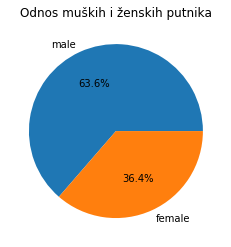

In [16]:
plt.pie(df['Sex'].value_counts(True).get_values()*100, labels=df['Sex'].value_counts(True).index, autopct='%1.1f%%',)

plt.title('Odnos muških i ženskih putnika')
plt.savefig('SexPie.png', dpi = 200)

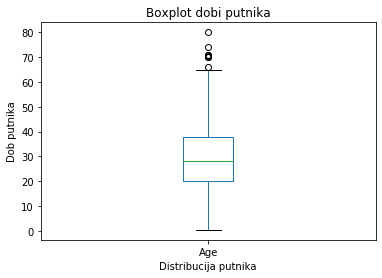

In [17]:
df['Age'].plot.box() 

plt.xlabel('Distribucija putnika')
plt.ylabel('Dob putnika')
plt.title('Boxplot dobi putnika')
plt.savefig('BoxAge.png', dpi=200)

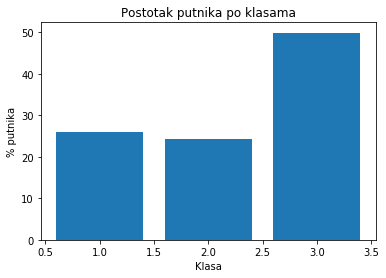

In [18]:
plt.bar(x=df['Pclass'].value_counts(True).index,  height=df['Pclass'].value_counts(True).get_values()*100)
plt.xlabel('Klasa')
plt.ylabel('% putnika')
plt.title('Postotak putnika po klasama')
plt.savefig('BarKlas.png', dpi=200)

## Scatter matrix

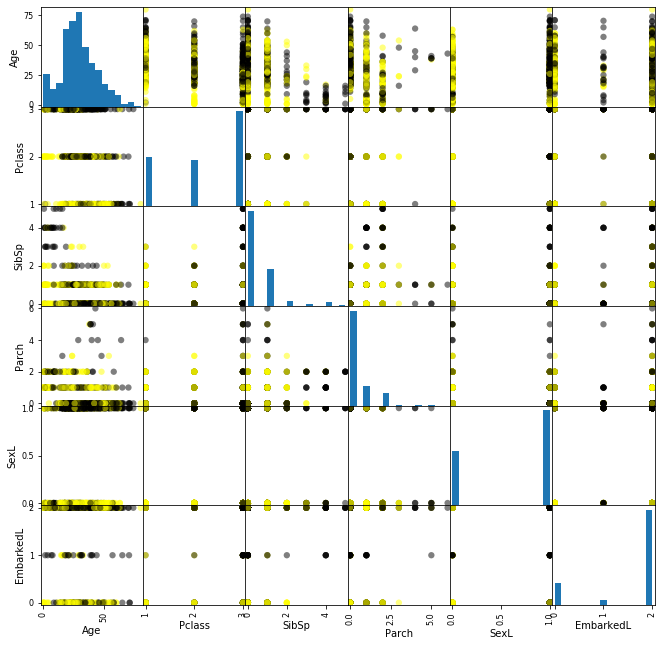

In [27]:
x = df[['Age', 'Pclass', 'SibSp', 'Parch', 'SexL', 'EmbarkedL']]
y = df['Survived']

cmap = cm.get_cmap('gnuplot')
scatter = pd.plotting.scatter_matrix(x, c = y, marker = 'o', s = 40, hist_kwds = {'bins': 15}, figsize=(11,11), cmap = cmap)
plt.savefig('ScatterMatrix.png', dpi=250)

## Train_test_split

In [42]:
X = df[['Age', 'Sex: male', 'Sex: female', 'Embarked: S', 'Embarked: C', 'Embarked: Q', 'Pclass', 'SibSp', 'Parch']]
y = df['Survived']

# KNN

## Scatter točnosti

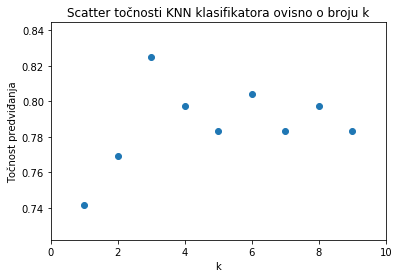

In [23]:
raspon_k = range(1,10)
scores = []

for k in raspon_k:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
    
plt.figure()
plt.title('Scatter točnosti KNN klasifikatora ovisno o broju k')
plt.xlabel('k')
plt.ylabel('Točnost predviđanja')
plt.scatter(raspon_k, scores)
plt.xticks([0,2,4,6,8,10])
plt.savefig('ScatterKNN.png', dpi = 200)

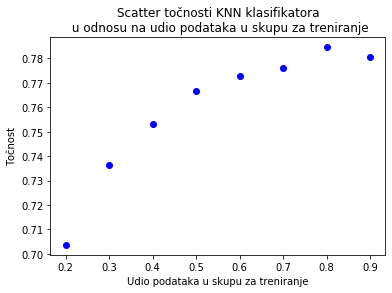

In [24]:
t = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]

knn = KNeighborsClassifier(n_neighbors=3)
plt.figure()
for s in t:
    scores = []
    for i in range(1,100):
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=1-s)
        knn.fit(X_train, y_train)
        scores.append(knn.score(X_test,y_test))
    plt.plot(s, np.mean(scores), 'bo')
plt.title('Scatter točnosti KNN klasifikatora\n u odnosu na udio podataka u skupu za treniranje')
plt.xlabel('Udio podataka u skupu za treniranje')
plt.ylabel('Točnost')
plt.savefig('ScatterKNN2.png', dpi = 200)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 0)

knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train, y_train)

print('Točnost na skupu za treniranje: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Točnost na skupu za testiranje: {:.2f}'
     .format(knn.score(X_test, y_test)))

Točnost na skupu za treniranje: 0.86
Točnost na skupu za testiranje: 0.83


In [ ]:
disp = plot_precision_recall_curve(classifier, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [584]:
print(knn_predicted, '\n')
print(y_test.values, '\n')

[0 0 1 1 0 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 1
 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 0 1 0 0 1 0 1 1 0 1 1 1
 0 0 1 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1] 

[0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1
 1 1 1 1 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 1 1
 0 0 1 1 0 0 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 0 1 1 0 1 0 1 0 0 0 0 1 0 0 0 0
 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1] 



In [25]:
pdpredict = pd.Series(knn.predict(X_test))
matrica_konfuzije = pd.crosstab(pdpredict.values, y_test.values)
matrica_konfuzije

(matrica_konfuzije.iloc[0,0] + matrica_konfuzije.iloc[1,1])/143

2.867132867132867

0.8902439024390244
0.7377049180327869


Text(0, 0.5, '% Točno klasificiranih')

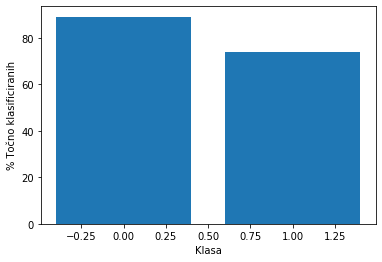

In [585]:
# Postotak ispravno klasificiranih iz klase 0
tn = matrica_konfuzije.iloc[0,0]/ (matrica_konfuzije.iloc[0,0] + matrica_konfuzije.iloc[1,0])
print(tn)

# Postotak ispravno klasificiranih iz klase 1
tp = matrica_konfuzije.iloc[1,1]/ (matrica_konfuzije.iloc[0,1] + matrica_konfuzije.iloc[1,1])
print(tp)

ispravno = pd.Series([tn,tp])
ispravno

plt.bar(x=ispravno.index, height=ispravno.values*100)
plt.xlabel('Klasa')
plt.ylabel('% Točno klasificiranih')

# Logistička regresija za klasifikaciju

In [43]:
X = df[['Age', 'Sex: male', 'Sex: female', 'Embarked: S', 'Embarked: C', 'Embarked: Q', 'Pclass', 'SibSp', 'Parch']]
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 0)

log_reg = LogisticRegression(solver = 'lbfgs', max_iter = 150)
log_reg.fit(X_train, y_train)

print('Slobodni koeficijent: ', log_reg.coef_, '\n')
print('Intercept: ', log_reg.intercept_, '\n')

print('Točnost na skupu za treniranje: {:.2f}'
     .format(log_reg.score(X_train, y_train)))
print('Točnost na skupu za testiranje: {:.2f}'
     .format(log_reg.score(X_test, y_test)))
coef = pd.DataFrame(log_reg.coef_)
coef

Slobodni koeficijent:  [[-0.04014433 -1.24252289  1.2449956  -0.13947287  0.43538759 -0.29344201
  -1.1480655  -0.40409871 -0.01913164]] 

Intercept:  [3.81582501] 

Točnost na skupu za treniranje: 0.80
Točnost na skupu za testiranje: 0.82


,0,1,2,3,4,5,6,7,8
0,-0.040144,-1.242523,1.244996,-0.139473,0.435388,-0.293442,-1.148066,-0.404099,-0.019132


In [27]:
koeficijenti = pd.DataFrame(log_reg.coef_)
koeficijenti.columns = ['Age', 'Sex: male', 'Sex: female', 'Embarked: S', 'Embarked: C', 'Embarked: Q', 'Pclass', 'SibSp', 'Parch']
koeficijenti

,Age,Sex: male,Sex: female,Embarked: S,Embarked: C,Embarked: Q,Pclass,SibSp,Parch
0,-0.040144,-1.242523,1.244996,-0.139473,0.435388,-0.293442,-1.148066,-0.404099,-0.019132


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


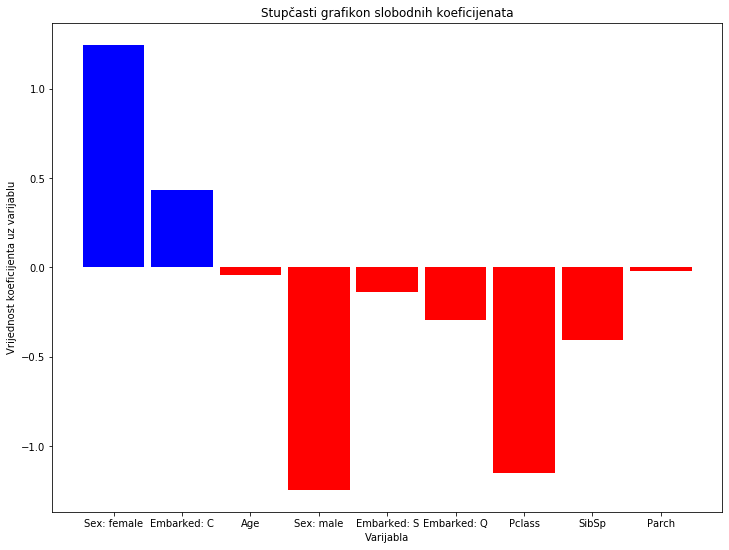

In [32]:
x = range(9)
y = range(2)
negative_data = [0, 0, -0.040144, -1.242523, -0.139473, -0.293442, -1.148066, -0.404099, -0.019132]
positive_data = [1.244996, 0.435388]

fig = plt.figure(figsize = (12,9))
xtickl = ('Sex: female', 'Embarked: C', 'Age', 'Sex: male', 'Embarked: S', 'Embarked: Q', 'Pclass', 'SibSp', 'Parch')
plt.xticks(np.arange(9), xtickl)
ax = plt.subplot(111)
ax.bar(x, negative_data, width=0.9, color='r')
ax.bar(y, positive_data, width=0.9, color='b')
plt.title('Stupčasti grafikon slobodnih koeficijenata')
plt.xlabel('Varijabla')
plt.ylabel('Vrijednost koeficijenta uz varijablu')
plt.savefig('BarCoef.png', dpi = 200)

In [598]:
print(lr_predicted, '\n')
print(y_test.values)

[1 0 1 0 0 0 1 0 0 1 1 1 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 1 1
 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 1 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 1 1 1 1 0 0 0 0 0 1] 

[0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1
 1 1 1 1 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 1 1
 0 0 1 1 0 0 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 0 1 1 0 1 0 1 0 0 0 0 1 0 0 0 0
 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


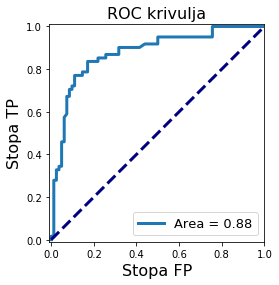

In [50]:
lr = LogisticRegression(solver = 'lbfgs', max_iter = 150)
y_score_lr = lr.fit(X_train, y_train).decision_function(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='Area = {:0.2f}'.format(roc_auc_lr))
plt.xlabel('Stopa FP', fontsize=16)
plt.ylabel('Stopa TP', fontsize=16)
plt.title('ROC krivulja', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.savefig('ROCkrivulja.png', dpi = 200)

# Neuronska mreža za klasifikaciju

In [48]:
X1 = df[['Age', 'Sex: male', 'Sex: female', 'Embarked: S', 'Embarked: C', 'Embarked: Q', 'Pclass', 'SibSp', 'Parch']]
y1 = df['Survived']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, train_size=0.75, random_state = 1)

nn = MLPClassifier(activation = 'tanh', hidden_layer_sizes = [100, 100], alpha = 5,
                   random_state = 0, solver='lbfgs').fit(X_train1, y_train1)

print('Točnost na skupu za treniranje: {:.2f}'
     .format(nn.score(X_train1, y_train1)))
print('Točnost na skupu za testiranje: {:.2f}'
     .format(nn.score(X_test1, y_test1)))

Točnost na skupu za treniranje: 0.84
Točnost na skupu za testiranje: 0.84


In [611]:
print(nn_predicted, '\n')
print(y_test1.values)

[0 0 1 0 0 0 1 0 0 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1
 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 1 1 0 1 1 1
 0 0 1 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0] 

[1 1 0 1 1 0 0 1 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 0 0 1 0 0 1 0 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 1 1 1 0 1 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 1 0 0 1 1 1
 0 0 1 1 0 1 0 0 1 1 0 0 0 0 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0
 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 1 0 1 0 1 0 0 1 1
 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 1 1 1 1]


# ROC krivulja

In [51]:
# Accuracy = TP + TN / (TP + TN + FP + FN)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)  
knn_predicted = knn.predict(X_test)
lr_predicted = lr.predict(X_test)
nn_predicted = nn.predict(X_test1)

print('Vrijednosti za KNN\nAccuracy: {:.2f}'.format(accuracy_score(y_test, knn_predicted)))
print('Precision: {:.2f}'.format(precision_score(y_test, knn_predicted)))
print('Recall: {:.2f}\n'.format(recall_score(y_test, knn_predicted)))

print('Vrijednosti za logistički regresor\nAccuracy: {:.2f}'.format(accuracy_score(y_test, lr_predicted)))
print('Precision: {:.2f}'.format(precision_score(y_test, lr_predicted)))
print('Recall: {:.2f}\n'.format(recall_score(y_test, lr_predicted)))

print('Vrijednosti za neuralnu mrežu\nAccuracy: {:.2f}'.format(accuracy_score(y_test1, nn_predicted)))
print('Precision: {:.2f}'.format(precision_score(y_test1, nn_predicted)))
print('Recall: {:.2f}'.format(recall_score(y_test1, nn_predicted)))

Vrijednosti za KNN
Accuracy: 0.83
Precision: 0.83
Recall: 0.74

Vrijednosti za logistički regresor
Accuracy: 0.82
Precision: 0.84
Recall: 0.70

Vrijednosti za neuralnu mrežu
Accuracy: 0.84
Precision: 0.84
Recall: 0.76


In [32]:
matrica_konfuzije1 = pd.crosstab(knn.predict(X_test), y_test.values, normalize = True)*100
print('Matrica konfuzije KNN klasifikatora: \n', matrica_konfuzije1, '\n')

matrica_konfuzije2 = pd.crosstab(log_reg.predict(X_test), y_test.values, normalize = True)*100
print('Matrica konfuzije logističkog regresora: \n', matrica_konfuzije2, '\n')

matrica_konfuzije3 = pd.crosstab(nn.predict(X_test1), y_test1.values, normalize = True)*100
print('Matrica konfuzije neuralne mreže: \n', matrica_konfuzije3)

Matrica konfuzije KNN klasifikatora: 
 col_0          0          1
row_0                      
0      48.251748  13.286713
1       9.090909  29.370629 

Matrica konfuzije logističkog regresora: 
 col_0          0          1
row_0                      
0      51.748252  12.587413
1       5.594406  30.069930 

Matrica konfuzije neuralne mreže: 
 col_0          0         1
row_0                     
0      51.123596  10.11236
1       6.179775  32.58427
